## Install libraries

In [ ]:
# %%capture
!pip install unsloth
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

In [43]:
%pip install langchain langchain-community
%pip install langchain-huggingface text-generation transformers google-search-results numexpr langchainhub sentencepiece jinja2 bitsandbytes accelerate langchain_experimental langchain-core

  Using cached transformers-4.47.0-py3-none-any.whl.metadata (43 kB)
  Using cached tokenizers-0.21.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached transformers-4.47.0-py3-none-any.whl (10.1 MB)
Using cached tokenizers-0.21.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.3
    Uninstalling transformers-4.46.3:
      Successfully uninstalled transformers-4.46.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chromadb 0.5.23 requires tokenizers<=0.20.3,>=0.13.2, but you have tokenizers 0.21.0 which is incompatible.
trl 0.12.2 requires transformers<

In [ ]:
!pip install -qU langchain-core

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download data

In [3]:
# download
!curl -L -o medquad.txt "https://drive.usercontent.google.com/download?id=1vn772jFJKqyJmZQTHNxp3Icbh87OHtmI&export=download&authuser=1&confirm=t&uuid=e0cdf556-e1c3-4026-a610-db3174c7d5da&at=APvzH3rXSJHxsBlim_ElYrv0Gx-x:1733834025040"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 21.5M  100 21.5M    0     0  5060k      0  0:00:04  0:00:04 --:--:-- 5061k


In [4]:
# download med textbooks
!curl -L -o med-textbooks.zip "https://drive.usercontent.google.com/download?id=19p9HkKr1Kfy7fPTMPuz8bm9bl1o5nwDK&export=download&authuser=1&confirm=t&uuid=dfd0e30e-03a6-480a-8ddf-06f0bd11de36&at=APvzH3qMVaqRJb-ZcaLklecsChbr:1733833958808"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 27.5M  100 27.5M    0     0  6574k      0  0:00:04  0:00:04 --:--:-- 7056k


In [5]:
!mkdir textbooks
!unzip med-textbooks.zip -d textbooks

Archive:  med-textbooks.zip
  inflating: textbooks/Immunology_Janeway.txt  
  inflating: textbooks/InternalMed_Harrison.txt  
  inflating: textbooks/Neurology_Adams.txt  
  inflating: textbooks/Obstentrics_Williams.txt  
  inflating: textbooks/Pathology_Robbins.txt  
  inflating: textbooks/Pathoma_Husain.txt  
  inflating: textbooks/Pediatrics_Nelson.txt  
  inflating: textbooks/Pharmacology_Katzung.txt  
  inflating: textbooks/Physiology_Levy.txt  
  inflating: textbooks/Psichiatry_DSM-5.txt  
  inflating: textbooks/Surgery_Schwartz.txt  
  inflating: textbooks/Anatomy_Gray.txt  
  inflating: textbooks/Biochemistry_Lippincott.txt  
  inflating: textbooks/Cell_Biology_Alberts.txt  
  inflating: textbooks/First_Aid_Step1.txt  
  inflating: textbooks/First_Aid_Step2.txt  
  inflating: textbooks/Gynecology_Novak.txt  
  inflating: textbooks/Histology_Ross.txt  


## Chunking

### Split medquad

In [6]:
from langchain_text_splitters import MarkdownHeaderTextSplitter
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [7]:
def medquad_chunker(file_path, chunk_size=2048, chunk_overlap=20):

    # Read medquad corpus
    with open(file_path) as f:
        medquad = f.read()

    # Split by markdown headers
    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
    ]
    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on, strip_headers=False)
    md_header_splits = markdown_splitter.split_text(medquad)

    # Second splitter by chunk_size
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )

    # Split
    splits = text_splitter.split_documents(md_header_splits)

    # Add metadata
    for idx, text in enumerate(splits):
        text.metadata['filename'] = 'medquad.txt'
    for idx, text in enumerate(splits):
        text.metadata['lowercase'] = text.page_content.lower()

    return splits

In [8]:
splits = medquad_chunker('medquad.txt')

In [9]:
lens = []
for idx, text in enumerate(splits):
    # print(idx, text)
    lens.append(len(text.page_content))
    # if idx == 100:
    #     break

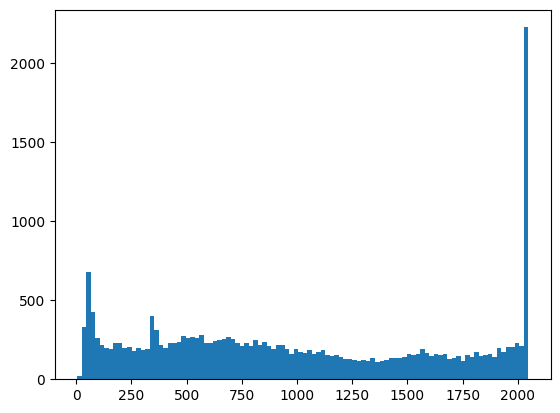

In [10]:
# make histogram of lens
import matplotlib.pyplot as plt
plt.hist(lens, bins=100)
plt.show()

### Split textbooks (MedQA)

In [50]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_experimental.text_splitter import SemanticChunker
import torch
import os
from tqdm import tqdm


In [12]:
def read_docs_from_folder(folder_dir):
    textbooks = {}
    for filename in os.listdir("textbooks"):
        if filename.endswith(".txt"):
            with open(os.path.join("textbooks", filename), "r") as f:
                textbooks[filename] = f.read()
    return textbooks

In [13]:
# List all used embeddings (list its model names)
# 'all-MiniLM-L6-v2', 'all-MiniLM-L12-v2', 'NeuML/pubmedbert-base-embeddings', 'abhinand/MedEmbed-base-v0.1'

def load_semantic_chunker(model_name):
    embeddings = HuggingFaceEmbeddings(
        model_name=model_name
    )
    text_splitter = SemanticChunker(
        embeddings,
        breakpoint_threshold_type="gradient" # Perfect mode for embedding based in domain special
    )

    return text_splitter

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/6.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/667 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/706k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [14]:

def textbook_chunker(model_name, folder_dir):
    textbooks = read_docs_from_folder(folder_dir)
    text_splitter = load_semantic_chunker(model_name)
    documents = []
    for filename, textbook in tqdm(textbooks.items()):
        docs = text_splitter.create_documents([textbook], [{'filename': filename}])
        documents.extend(docs)
    return documents

In [ ]:
documents = textbook_chunker('NeuML/pubmedbert-base-embeddings', 'textbooks')

In [ ]:
import pickle

# Specify the filename for the pickle file
pkl_filename = "drive/MyDrive/documents_embed_medembed.pkl"

# Save the docs splitted by semantic
with open(pkl_filename, "wb") as f:
    pickle.dump(documents, f)

print(f"Documents saved to {pkl_filename}")

Documents saved to drive/MyDrive/documents_embed_medembed.pkl


## Rewrite Query

In [1]:
# Download test data
!curl -L -o test_combined.csv "https://drive.usercontent.google.com/download?id=18CZaVzpSVrHEXlI4qkqyJy6AvWDdv-B4&export=download&authuser=1&confirm=t&uuid=08d3a4cb-1a35-4e48-9be7-ff5f4fd07c1a&at=APvzH3oU5ikkJ5HdjrYfK9mmUb8t:1733909734290"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7996k  100 7996k    0     0  1476k      0  0:00:05  0:00:05 --:--:-- 1902k


In [1]:
# %%capture
!pip install unsloth
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

Found existing installation: unsloth 2024.12.4
Uninstalling unsloth-2024.12.4:
  Successfully uninstalled unsloth-2024.12.4
  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-oxu1gnmc/unsloth_ca180fdf0b5a4c6999dfb24d2b5f51d6
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-oxu1gnmc/unsloth_ca180fdf0b5a4c6999dfb24d2b5f51d6
  Resolved https://github.com/unslothai/unsloth.git to commit 85f1fa096afde5efe2fb8521d8ceec8d13a00715
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 123.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 209.1 MB/s eta 0:00:00
  Created wheel for unsloth: filename=unsloth-2024.12.4-py3-none-any.whl size=173746 sha256=e69f39a81c6ce0f052100a5

In [2]:
from unsloth import FastLanguageModel
import torch

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen2.5-7B-Instruct",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)
FastLanguageModel.for_inference(model)

==((====))==  Unsloth 2024.12.4: Fast Qwen2 patching. Transformers:4.46.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 3584, padding_idx=151665)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear4bit(in_features=3584, out_features=3584, bias=True)
          (k_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
          (v_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
          (o_proj): Linear4bit(in_features=3584, out_features=3584, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
          (up_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
          (down_proj): Linear4bit(in_features=18944, out_features=3584, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((

In [4]:
import pandas as pd

df_test = pd.read_csv("test_combined.csv")

### Few-shot rewrite

In [7]:
import re

In [30]:
def few_shot_rewrite(question):
    system_rewrite = """You are a helpful assistant that provide a better search query for \
web search engine to answer the given question."""

    question_template = "Question: {QUESTION}"
    answer_template = "Answer: {ANSWER}"

    messages = [
        {'role': 'system', 'content': system_rewrite},
        {'role': 'user', 'content': question_template.replace('{QUESTION}', 'I have got cough for several month, sometimes my cough includes too much mucus in it. What disease that I have? I dont know what to do please help me')},
        {'role': 'assistant', 'content': answer_template.replace('{ANSWER}', 'What diseases have coughing up a lot of mucus as a symptom?')},
        {'role': 'user', 'content': question_template.replace('{QUESTION}', 'Last time I checked with the machine, it says that I have high blood pressure. What should I do to handle it?')},
        {'role': 'assistant', 'content': answer_template.replace('{ANSWER}', 'What are the treatments for high blood pressure?')},
        {'role': 'user', 'content': question_template.replace('{QUESTION}', 'My friend said I should get the tetanus vaccine because tetanus is a very dangerous disease. What is tetanus anyway?')},
        {'role': 'assistant', 'content': answer_template.replace('{ANSWER}', 'What is tetanus?')},
        {'role': 'user', 'content': question_template.replace('{QUESTION}', question)},
    ]
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize = True,
        add_generation_prompt = True, # Must add for generation
        return_tensors = "pt",
    ).to("cuda")

    # Decode inputs
    # print(tokenizer.decode(inputs[0]))

    outputs = model.generate(input_ids = inputs, max_new_tokens = 128, use_cache = True,
                         temperature = 0.5, min_p = 0.1, repetition_penalty=1.0)

    # check match for '<|im_start|>assistant' in tokenizer.batch_decode(outputs)[0]
    match_assistant = re.search(r'<\|im_start\|>assistant', tokenizer.batch_decode(outputs)[0])
    # print(match_assistant.end())
    # print(tokenizer.batch_decode(outputs)[0][match_assistant.end():])

    # Get end span until the end
    rewrited_query = tokenizer.batch_decode(outputs)[0].split(sep='\n')[-1].replace('<|im_end|>', '').replace('Answer: ', '').replace('"', '').strip()

    # return rewrited_query
    return rewrited_query


In [31]:
rewrited_query = few_shot_rewrite('I am really curious about this. Could you tell what is pneumonia?')
print(rewrited_query)

What is pneumonia?


### Multiple queries

In [37]:
def multiple_queries_rewrite(question):
    system_template = """You are a helpful assistant that generates search queries based on a single input query.

Perform query decomposition if necessary. Given a user question, break it down into distinct sub questions that \
you need to answer in order to answer the original question. Only write the questions separated \
by ;.

If there are acronyms or words you are not familiar with, do not try to rephrase them."""

    question_template = "Question: {QUESTION}"
    answer_template = "Answer: {ANSWER}"

    messages = [
        {'role': 'system', 'content': system_template},
        {'role': 'user', 'content': question_template.replace('{QUESTION}', 'I have got cough for several month, sometimes my cough includes too much mucus in it. What disease that I have and how to treat this? I really feel uncomfortable because of this.')},
        {'role': 'assistant', 'content': answer_template.replace('{ANSWER}', 'What diseases have coughing up a lot of mucus as a symptom?;How to treat disease that have a lot of mucus as a symptom?')},
        {'role': 'user', 'content': question_template.replace('{QUESTION}', 'Last time I checked with the machine, it says that I have high blood pressure. How do I have this disease? What should I do to handle it?')},
        {'role': 'assistant', 'content': answer_template.replace('{ANSWER}', 'What are the causes of high blood pressure;What are the treatments for high blood pressure?')},
        {'role': 'user', 'content': question_template.replace('{QUESTION}', 'what is pneumonia, its symptoms, and how to treat it? I am worried because i heard that if you feel hurt in your throat, it can be the cause.')},
        {'role': 'assistant', 'content': answer_template.replace('{ANSWER}', 'What is pneumonia?; What are the symptoms of pneumonia?; What are the treatments for pneumonia')},
        {'role': 'user', 'content': question_template.replace('{QUESTION}', question)},
    ]
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize = True,
        add_generation_prompt = True, # Must add for generation
        return_tensors = "pt",
    ).to("cuda")

    # Decode inputs
    # print(tokenizer.decode(inputs[0]))

    outputs = model.generate(input_ids = inputs, max_new_tokens = 128, use_cache = True,
                         temperature = 0.5, min_p = 0.1, repetition_penalty=1.0)

    # print(tokenizer.batch_decode(outputs)[0])

    # check match for '<|im_start|>assistant' in tokenizer.batch_decode(outputs)[0]
    match_assistant = re.search(r'<\|im_start\|>assistant', tokenizer.batch_decode(outputs)[0])

    # Get end span until the end
    rewrited_query = tokenizer.batch_decode(outputs)[0].split(sep='\n')[-1].replace('<|im_end|>', '').replace('Answer: ', '').replace('"', '').strip()

    return rewrited_query

In [44]:
rewrited_query = multiple_queries_rewrite('I am really curious about this. Could you tell what is pneumonia and how to treat this?')
print(rewrited_query)

What is pneumonia?; How to treat pneumonia?


### HyDE

In [41]:
def hyde_rewrite(question):
    system_template = """
    You are an expert at using a question to generate a document useful for answering the question. \
    Given a question, generate a paragraph of text (3-4 sentences) that answers the question."""

    question_template = "Question: {QUESTION}"
    answer_template = "Answer: {ANSWER}"

    messages = [
        {'role': 'system', 'content': system_template},
        {'role': 'user', 'content': question_template.replace('{QUESTION}', question)},
    ]
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize = True,
        add_generation_prompt = True, # Must add for generation
        return_tensors = "pt",
    ).to("cuda")

    # Decode inputs
    # print(tokenizer.decode(inputs[0]))

    outputs = model.generate(input_ids = inputs, max_new_tokens = 256, use_cache = True,
                         temperature = 0.5, min_p = 0.1, repetition_penalty=1.0)

    # print(tokenizer.batch_decode(outputs)[0])

    import re

    # check match for '<|im_start|>assistant' in tokenizer.batch_decode(outputs)[0]
    match_assistant = re.search(r'<\|im_start\|>assistant', tokenizer.batch_decode(outputs)[0])

    # Get end span until the end
    rewrited_query = tokenizer.batch_decode(outputs)[0][match_assistant.end():].replace('<|im_end|>', '').replace('**', '').replace('"', '').strip()

    return rewrited_query

In [42]:
rewrited_query = hyde_rewrite('I am really curious about this. Could you tell what is pneumonia and how to treat this?')
print(rewrited_query)

Pneumonia is a lung infection that inflames the air sacs in one or both lungs, often filling these air sacs with fluid or pus, which makes it hard to breathe. Treatment typically involves antibiotics for bacterial pneumonia, and in some cases, antiviral medications for viral pneumonia. Additionally, treatments may include over-the-counter pain relievers and cough suppressants to alleviate symptoms, as well as rest and hydration to help the body fight the infection.


## Retrieval


### TF-IDF

In [ ]:
from langchain_community.retrievers import TFIDFRetriever

In [ ]:
retriever = TFIDFRetriever.from_documents(all_documents, k=1)

In [ ]:
result = retriever.invoke("What causes pneumonia?", k=3)

In [ ]:
for r in result:
    print(len(r.page_content))

2405


In [ ]:
print(r.page_content)

9.4)

B. Caused by a variety of bacterial organisms (Table 9.2)

IV. A. Characterized by diffuse interstitial infiltrates (Fig. 9.5)

B. Presents with relatively mild upper respiratory symptoms (minimal sputum and low fever); 'atypical' presentation

C. Caused by bacteria or viruses (Table 9.3)

V. A. Seen in patients at risk for aspiration (e.g., alcoholics and comatose patients)

B. Most often due to anaerobic bacteria in the oropharynx (e.g., Bacteroides, Fusobacterium, and Peptococcus)

Fig. 9.4 Bronchopneumonia. A, X-ray appearance. B, Gross appearance. (B, Courtesy of Yale Rosen, MD)

Fig. 9.5 Interstitial pneumonia. A, X-ray appearance. B, Inflammatory infiltrate involving interstitium. Table 9.2: Causes of Bronchopneumonia 2nd most common cause of secondary pneumonia; often complicated by abscess or empyema

Common cause of secondary pneumonia and pneumonia superimposed on COPD (leads to exacerbation of COPD)

Community-acquired pneumonia and pneumonia superimposed on COPD (lea

### BM25

In [ ]:
%pip install --upgrade --quiet rank_bm25

In [ ]:
import nltk

nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from langchain_community.retrievers import BM25Retriever

In [ ]:
from nltk.tokenize import word_tokenize

retriever = BM25Retriever.from_documents(
    all_docs,
    k=2,
    # preprocess_func=word_tokenize,
)

In [ ]:
docs = retriever.invoke("I have symptoms of blood coughing and fever, what disease am i getting? And then how to handle it?")
for doc in docs:
    print(doc.page_content)

## Who is at risk for I Can Lower My Risk for Type 2 Diabetes: A Guide for American Indians? ?
- My mother had diabetes when I was born.   - I am overweight.  - I have a parent, brother, or sister with diabetes.  - My family background is American Indian.  - I have had gestational diabetes, or I gave birth to at least one baby weighing more than 9 pounds.  - My blood pressure is 140/90 mmHg or higher, or I have been told that I have high blood pressure.  - My cholesterol levels are higher than normal. My HDL cholesterol"good" cholesterolis below 35 mg/dL, or my triglyceride level is above 250 mg/dL.  - I am fairly inactive. I exercise fewer than three times a week.  
## Who is at risk for I Can Lower My Risk for Type 2 Diabetes: A Guide for American Indians? ?
- Reach and maintain a reasonable body weight.  - Make wise food choices most of the time.  - Be physically active every day.  - Take your prescribed medicines.  
Doing these things can reduce your risk of developing type 2 diabe

### Vector DB Search

In [45]:
!pip install --upgrade --quiet faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.1 MB/s eta 0:00:00


In [46]:
# Download documents_embed_l6.pkl
!curl -L -o documents_embed_l6.pkl "https://drive.usercontent.google.com/download?id=1--zroryJQ0M2T3ahDZ9Emd5IVY0Ff9VS&export=download&authuser=1&confirm=t&uuid=0b75c9c1-7440-430f-85f4-72df72d811d7&at=APvzH3qlz28zfFY6RISmhAKE8vWE:1733923944700"

# Download documents_embed_l12.pkl
!curl -L -o documents_embed_l12.pkl "https://drive.usercontent.google.com/download?id=1t5O_MSmYSUgIJE7L_0zcBo5Yy-A_8mCB&export=download&authuser=1&confirm=t&uuid=5d1fd383-f740-45ee-9b08-8de1ac5b354d&at=APvzH3p9l6s3FYJb5-V1EbXk9UZg:1733923989343"

# Download documents_embed_medembed.pkl
!curl -L -o documents_embed_medembed.pkl "https://drive.usercontent.google.com/download?id=1Ybv88XZsfneGmeOZw-hxIT--tL7HIt3R&export=download&authuser=1&confirm=t&uuid=46414804-d639-4432-8211-40191c8ace1c&at=APvzH3pP4n5cwQNHvTOVonmHQDBU:1733924043480"

# Download documents_embed_pubmedbert.pkl
!curl -L -o documents_embed_pubmedbert.pkl "https://drive.usercontent.google.com/download?id=1--rlefgX9jRoU9KjaFYMTGTN0J7Z-ap3&export=download&authuser=1&confirm=t&uuid=7871cc11-f4dd-4a65-b1a6-05a072c748fa&at=APvzH3oU66BiD4SgvvpscvI0dEvQ:1733924083190"

# Download FAISS vectorstores
!curl -L -o vector_db.zip "https://drive.usercontent.google.com/download?id=1yjF7rgnOYaUiFD_LP6n6gASUPv2I-a9p&export=download&authuser=0&confirm=t&uuid=0f876250-d487-4a0e-94cc-42ad038b07cc&at=APvzH3ran-6UJYtTm0zefZhxqM4o:1733936759759"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 87.1M  100 87.1M    0     0  11.4M      0  0:00:07  0:00:07 --:--:-- 25.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 87.1M  100 87.1M    0     0  8793k      0  0:00:10  0:00:10 --:--:-- 22.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 87.1M  100 87.1M    0     0  11.1M      0  0:00:07  0:00:07 --:--:-- 24.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 87.1M  100 87.1M    0     0  12.0M      0  0:00:07  0:00:07 --:--:-- 22.1M
  % Total    % Received % Xferd  Average Speed   Tim

In [47]:
import pickle
# Read documents_embedl6.pkl
with open("documents_embed_pubmedbert.pkl", "rb") as f:
    documents = pickle.load(f)

In [55]:
!unzip vector_db.zip -d /content/A

Archive:  vector_db.zip
replace /content/content/drive/MyDrive/tubes_nlp/db-embeddings/faiss-l6/index.faiss? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/content/drive/MyDrive/tubes_nlp/db-embeddings/faiss-l6/index.faiss  
  inflating: /content/content/drive/MyDrive/tubes_nlp/db-embeddings/faiss-l6/index.pkl  
  inflating: /content/content/drive/MyDrive/tubes_nlp/db-embeddings/faiss-l12/index.faiss  
  inflating: /content/content/drive/MyDrive/tubes_nlp/db-embeddings/faiss-l12/index.pkl  
  inflating: /content/content/drive/MyDrive/tubes_nlp/db-embeddings/faiss-medembed/index.faiss  
  inflating: /content/content/drive/MyDrive/tubes_nlp/db-embeddings/faiss-medembed/index.pkl  
  inflating: /content/content/drive/MyDrive/tubes_nlp/db-embeddings/faiss-pubmedbert/index.faiss  
  inflating: /content/content/drive/MyDrive/tubes_nlp/db-embeddings/faiss-pubmedbert/index.pkl  


In [ ]:
all_docs = splits + documents
len(all_docs)

57959

In [53]:
from langchain.vectorstores import FAISS

In [ ]:
faiss = FAISS.from_documents(all_docs, embeddings_pubmedbert)

In [ ]:
query = "How does my immune system works?"
docs = faiss.similarity_search(query, k=3)
for doc in docs:
    print(doc.page_content)

# Immune System and Disorders  
## What is (are) Immune System and Disorders ?
Your immune system is a complex network of cells, tissues, and organs that work together to defend against germs. It helps your body to recognize these "foreign" invaders. Then its job is to keep them out, or if it can't, to find and destroy them.    If your immune system cannot do its job, the results can be serious. Disorders of the immune system include       - Allergy and asthma - immune responses to substances that are usually not harmful    - Immune deficiency diseases - disorders in which the immune system is missing one or more of its parts    - Autoimmune diseases - diseases causing your immune system to attack your own body's cells and tissues by mistake       NIH: National Institute of Allergy and Infectious Diseases
Nat. Rev. Microbiol. 9, 860–875. Welch MD & Way M (2013) Arp2/3-mediated actin-based motility: a tail of pathogen abuse. Cell Host Microbe 14, 242–255. The Innate and Adaptive Immune 

In [ ]:
vector_store = FAISS.load_local("faissv1.faiss", embeddings_l6, allow_dangerous_deserialization=True)

In [58]:
rewrited_query

'What is pneumonia?; How to treat pneumonia?'

In [59]:
query = ""
docs = vector_store.similarity_search(rewrited_query, k=3)
for doc in docs:
    print(doc.page_content)

## What are the treatments for Pneumonia ?
Treatment for pneumonia depends on the type of pneumonia you have and how severe it is. Most people who have community-acquired pneumoniathe most common type of pneumoniaare treated at home.  
The goals of treatment are to cure the infection and prevent complications.  
General Treatment  
If you have pneumonia, follow your treatment plan, take all medicines as prescribed, and get ongoing medical care. Ask your doctor when you should schedule followup care. Your doctor may want you to have a chest x ray to make sure the pneumonia is gone.  
Although you may start feeling better after a few days or weeks, fatigue (tiredness) can persist for up to a month or more. People who are treated in the hospital may need at least 3 weeks before they can go back to their normal routines.  
Bacterial Pneumonia  
Bacterial pneumonia is treated with medicines called antibiotics. You should take antibiotics as your doctor prescribes. You may start to feel bett

In [ ]:
!mkdir /content/drive/MyDrive/tubes_nlp

In [ ]:
faiss.save_local("drive/MyDrive/tubes_nlp/faiss-pubmedbert")

#### Load local

In [51]:
embeddings = HuggingFaceEmbeddings(
    model_name='NeuML/pubmedbert-base-embeddings'
)

In [56]:
vector_store = FAISS.load_local("/content/content/drive/MyDrive/tubes_nlp/db-embeddings/faiss-pubmedbert", embeddings, allow_dangerous_deserialization=True)